Download the data - after extracting features through a processing block - so we can train a machine learning model.

In [1]:
import numpy as np
import requests

API_KEY = 'ei_3c5808f2fc3861a086e7091325c13812d1090b11c8ae02af5b5d3e5a2cdf2da8'

def download_data(url):
    response = requests.get(url, headers={'x-api-key': API_KEY})
    if response.status_code == 200:
        return response.content
    else:
        print(response.content)
        raise ConnectionError('Could not download data file')

X = download_data('https://studio.edgeimpulse.com/v1/api/51070/training/6/x')
Y = download_data('https://studio.edgeimpulse.com/v1/api/51070/training/6/y')


Store the data in a temporary file, and load it back through Numpy.

In [2]:
with open('x_train.npy', 'wb') as file:
    file.write(X)
with open('y_train.npy', 'wb') as file:
    file.write(Y)
X = np.load('x_train.npy')
Y = np.load('y_train.npy')[:,0]

In [3]:
X.shape, Y.shape

((10000, 3072), (10000,))

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt

	 Label Image==>  2


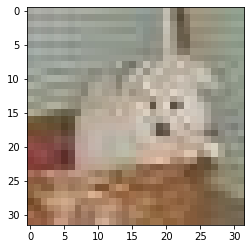

In [12]:
image = X[0]
label = Y[0]
reshape_to = (32,32,3)

print("\t Label Image==> ",label)
img = tf.reshape(image, reshape_to)
plt.imshow(img);

Define our labels and split the data up in a test and training set:

In [13]:
import sys, os, random
from sklearn.model_selection import train_test_split

# Set random seeds for repeatable results
RANDOM_SEED = 3
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

classes_values = [ "cat", "dog" ]
classes = len(classes_values)
classes

2

In [14]:
Y

array([2, 2, 2, ..., 1, 1, 1], dtype=int32)

In [15]:
set(Y)

{1, 2}

In [16]:
Y = tf.keras.utils.to_categorical(Y - 1, classes)
Y

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [17]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

print(X_train.shape, Y_test.shape)
print(X_test.shape, Y_test.shape)

(8000, 3072) (2000, 2)
(2000, 3072) (2000, 2)


In [18]:
input_length = X_train[0].shape[0]
input_length

3072

The [tf.data API](https://www.tensorflow.org/guide/data) enables you to build complex input pipelines from simple, reusable pieces. For example, the pipeline for an image model might aggregate data from files in a distributed file system, apply random perturbations to each image, and merge randomly selected images into a batch for training.

In [20]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
validation_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

In [22]:
print(train_dataset)
print(validation_dataset)

<TensorSliceDataset shapes: ((3072,), (2,)), types: (tf.float32, tf.float32)>
<TensorSliceDataset shapes: ((3072,), (2,)), types: (tf.float32, tf.float32)>


In [23]:
def get_reshape_function(reshape_to):
    def reshape(image, label):
        return tf.reshape(image, reshape_to), label
    return reshape

callbacks = []

Train the model:

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, InputLayer, Dropout, Conv1D, Conv2D, Flatten, Reshape, MaxPooling1D, MaxPooling2D, BatchNormalization, TimeDistributed
from tensorflow.keras.optimizers import Adam

# model architecture
model = Sequential()
model.add(Conv2D(32, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Conv2D(64, kernel_size=3, activation='relu', kernel_constraint=tf.keras.constraints.MaxNorm(1), padding='same'))
model.add(MaxPooling2D(pool_size=2, strides=2, padding='same'))
model.add(Flatten())
model.add(Dense(64, activation='relu',
    activity_regularizer=tf.keras.regularizers.l1(0.00001)))
model.add(Dense(classes, activation='softmax', name='y_pred'))

In [29]:
# this controls the learning rate
opt = Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [30]:
# This is only required for some input types, e.g. images
SPECIFIC_INPUT_SHAPE = (32, 32, 3)

train_dataset = train_dataset.map(get_reshape_function(SPECIFIC_INPUT_SHAPE), tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(get_reshape_function(SPECIFIC_INPUT_SHAPE), tf.data.experimental.AUTOTUNE)

In [31]:
print(train_dataset)
print(validation_dataset)

<ParallelMapDataset shapes: ((32, 32, 3), (2,)), types: (tf.float32, tf.float32)>
<ParallelMapDataset shapes: ((32, 32, 3), (2,)), types: (tf.float32, tf.float32)>


In [32]:
# this controls the batch size, or you can manipulate the tf.data.Dataset objects yourself
BATCH_SIZE = 32
train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=False)
validation_dataset = validation_dataset.batch(BATCH_SIZE, drop_remainder=False)

In [33]:
print(train_dataset)
print(validation_dataset)

<BatchDataset shapes: ((None, 32, 32, 3), (None, 2)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 32, 32, 3), (None, 2)), types: (tf.float32, tf.float32)>


In [34]:
# compile the model
model.compile(
    loss='categorical_crossentropy', 
    optimizer=opt, 
    metrics=['accuracy']
    )

In [35]:
# train the neural network
history = model.fit(
    train_dataset, 
    epochs=10, 
    validation_data=validation_dataset, 
    verbose=2, 
    callbacks=callbacks
    )

Epoch 1/10
250/250 - 15s - loss: 0.6650 - accuracy: 0.5897 - val_loss: 0.6713 - val_accuracy: 0.5785
Epoch 2/10
250/250 - 13s - loss: 0.6099 - accuracy: 0.6654 - val_loss: 0.6262 - val_accuracy: 0.6525
Epoch 3/10
250/250 - 13s - loss: 0.5703 - accuracy: 0.7013 - val_loss: 0.5952 - val_accuracy: 0.6845
Epoch 4/10
250/250 - 13s - loss: 0.5394 - accuracy: 0.7244 - val_loss: 0.5992 - val_accuracy: 0.6900
Epoch 5/10
250/250 - 13s - loss: 0.5097 - accuracy: 0.7481 - val_loss: 0.5896 - val_accuracy: 0.7035
Epoch 6/10
250/250 - 13s - loss: 0.4799 - accuracy: 0.7670 - val_loss: 0.6034 - val_accuracy: 0.7010
Epoch 7/10
250/250 - 13s - loss: 0.4486 - accuracy: 0.7885 - val_loss: 0.6286 - val_accuracy: 0.7040
Epoch 8/10
250/250 - 13s - loss: 0.4144 - accuracy: 0.8070 - val_loss: 0.6420 - val_accuracy: 0.7050
Epoch 9/10
250/250 - 14s - loss: 0.3756 - accuracy: 0.8320 - val_loss: 0.6554 - val_accuracy: 0.7150
Epoch 10/10
250/250 - 14s - loss: 0.3376 - accuracy: 0.8554 - val_loss: 0.6899 - val_accura

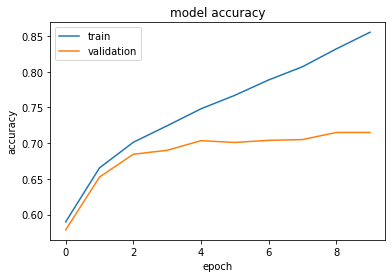

In [38]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Save the model to disk
model.save('saved_model')